In [159]:
%matplotlib inline

from google.colab import files, drive    # upload
import numpy as np                       # mathematical calculations
from io import BytesIO                   # reading files
from PIL import Image             # image processing library
import matplotlib.pyplot as plt   # plotting library
from scipy import signal
import math

In [160]:
drive.mount('drive')
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Image Blending/landscape.jpeg")
im = np.array(img)
so = Image.open("/content/drive/MyDrive/Colab Notebooks/Image Blending/moon.jpeg")
soccer = np.array(so)
b = Image.open("/content/drive/MyDrive/Colab Notebooks/Image Blending/cloudy night.jpeg")
basketball = np.array(b)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


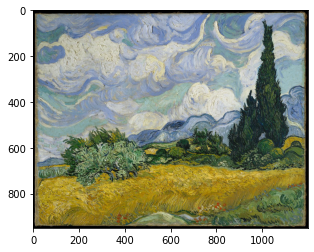

In [161]:
plt.imshow(im)

In [162]:
print(im.shape)

(950, 1200, 3)


(300, 500, 3)


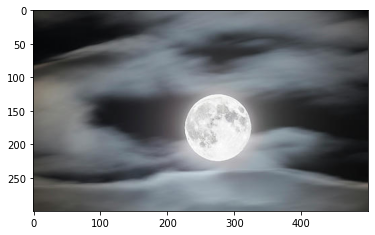

In [163]:
soccer = soccer[100:400, 200:700, :]
plt.imshow(soccer)
print(soccer.shape)

(300, 500, 3)


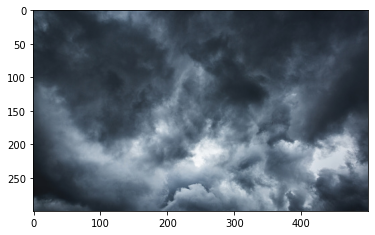

In [164]:
basketball = basketball[:300, 9:, :]
plt.imshow(basketball)
print(basketball.shape)

## GUASSIAN PYRAMID

When done sampling by a factor of 16

1. smooth the original resolution image
2. downsample by a factor of 
3. repeat process 3 more times

L0. = full resolution
L1. = downsample by 2^1
LN. = downsample by 2^N


In [165]:
smoothing_kern = np.ones((5,5))/25


In [166]:
def convert_uint8(im):
  return np.uint8(255*im/im.max())

In [167]:
# Downsampling Method 1

def down_sample_one(im, n, kern):
  """
  Downsample an input rgb image by a factor of 2
  """
  if n == 0:
    return im
  return down_sample_one(im [::2, ::2, :], n-1, kern)

def convolve_rgb(rgb_im, kern):
  """
  take in 3D image and multiply by kernal
  """
  result = np.zeros(rgb_im.shape, dtype=np.float32)
  result[:,:,0] = signal.convolve2d(rgb_im[:, :, 0], smoothing_kern, mode='same')
  result[:,:,1] = signal.convolve2d(rgb_im[:, :, 1], smoothing_kern, mode='same')
  result[:,:,2] = signal.convolve2d(rgb_im[:, :, 2], smoothing_kern, mode='same')
  return result

In [168]:
def up_sample(im, dimensions):
  test_upsample = np.zeros(dimensions, dtype = np.float32)
  test_upsample[::2, ::2, :] = im

  if test_upsample.shape[0] % 2 == 0:
    height = test_upsample.shape[0] - 1
  else:
    height = test_upsample.shape[0]

  if test_upsample.shape[1] % 2 == 0:
    width = test_upsample.shape[1] - 1
  else:
    width = test_upsample.shape[1]



  for i in range(width):
    for z in range(height):
      if i%2 != 0 and z%2 != 0:
        average = test_upsample[z-1,i-1,:] + test_upsample[z-1,i+1,:] + test_upsample[z+1,i-1,:] + test_upsample[z+1,i+1,:]
        average = average/4
        test_upsample[z,i,:] = average
      elif i%2 != 0 and z%2 == 0:
        average = test_upsample[z,i-1,:] + test_upsample[z,i+1,:]
        average = average/2
        test_upsample[z,i,:] = average
      elif i%2 == 0 and z%2 != 0:
        average = test_upsample[z-1,i,:] + test_upsample[z+1,i,:]
        average = average/2
        test_upsample[z,i,:] = average

    if width < test_upsample.shape[1]:
      test_upsample[:,width,:] = test_upsample[:,width-1,:]

    if height < test_upsample.shape[0]:
      test_upsample[height,:,:] = test_upsample[height-1,:,:]


  return test_upsample



In [169]:
def guassian_pyramid(im, level, kern=smoothing_kern):
  if level == 0:
    return im
  im = convolve_rgb(im, kern)
  return guassian_pyramid(im [::2, ::2, :], level-1, kern)

In [170]:
def lapplacian_pyramid(i, level, kern=smoothing_kern):
  g = guassian_pyramid(i, level, kern)
  next_g = guassian_pyramid(i, level+1, kern)
  u = up_sample(next_g, g.shape)
  l = g - u
  return l

In [171]:
def image_combining(im, n):
  y, x, z = im.shape
  im_x = 0
  im_y = 0
  result = np.zeros([y, int(1.5*x), z], dtype=np.uint8)
  gp = guassian_pyramid(im, 0)
  y2, x2, z2 = gp.shape
  result[0:y2, 0: x2, :] = gp
  im_x = x2
  for i in range(1, n):
    gp = guassian_pyramid(im, i)
    y2, x2, z2 = gp.shape
    result[im_y: im_y + y2, im_x: (im_x + x2), :] = gp
    im_y = im_y + y2
  return result

In [172]:
def image_combining_lapplasian(im, n):
  y, x, z = im.shape
  im_x = 0
  im_y = 0
  result = np.zeros([y, int(1.5*x), z], dtype=np.uint8)
  gp = lapplacian_pyramid(im, 0)
  y2, x2, z2 = gp.shape
  result[0:y2, 0: x2, :] = gp
  im_x = x2
  for i in range(1, n):
    gp = lapplacian_pyramid(im, i)
    y2, x2, z2 = gp.shape
    result[im_y: im_y + y2, im_x: (im_x + x2), :] = gp
    im_y = im_y + y2
  return result

(300, 500, 3)
(300, 500, 3)


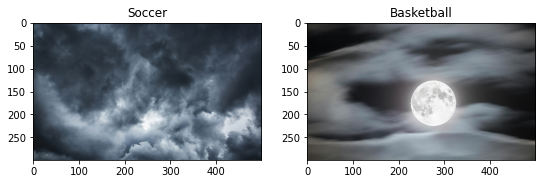

In [173]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=[9, 4])
ax0.set_title("Soccer")
ax1.set_title("Basketball")

im0 = ax0.imshow(basketball)
im1 = ax1.imshow(soccer)
print(basketball.shape)
print(soccer.shape)

In [174]:
def find_power(im):
  x,y,_ = im.shape
  i = 0
  i = math.ceil(math.log(max(x,y),2))
  return int(i)
  
def find_avg(im):
  top = np.zeros((1,1,3), dtype=np.float32)
  means = im.mean(axis=0).mean(axis=0)
  top[:,:,0] = means[0]
  top[:,:,1] = means[1]
  top[:,:,2] = means[2]
  return top

def collapse(im, i, kern=smoothing_kern):
  """"
  Finds the gaussian image at the given level using only laplacians
  you should check the ouput of this function with your gaussian pyramid function
  Check: plot the differnce (collapse - gaussian pyramid)
  G_i = L_i + upsample(L_i+1 + upsample(L_i+2+upsample(...)))

  Inputs:
    im = full res image
    level = level you want to output
  Output:
    Gaussian at level
  """
  top = find_avg(im)
  top_n = find_power(im)
  target = top_n - i
  gaussian = top
  for y in range(1, top_n):
    if (y == target):
      return gaussian
    else:
      print(gaussian.shape)
      print(lapplacian_pyramid(im, top_n-y-1).shape)
      gaussian = up_sample(gaussian, lapplacian_pyramid(im, top_n-y-1).shape) + lapplacian_pyramid(im, top_n-y-1)


In [175]:
def create_circular_mask(h, w, center=None, radius=None):
    """
    https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    """

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [176]:
#https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
h, w = soccer.shape[:2]
center = (int(w/2)+25, int(h/2)+25)
radius = h/6
mask = create_circular_mask(h, w, center=center, radius=radius)
whiteblankimage = 1 * np.ones(shape=[h, w, 3], dtype=np.float32)
masked_img = whiteblankimage.copy()
masked_img[~mask] = 0

Text(0.5, 1.0, 'composite image')

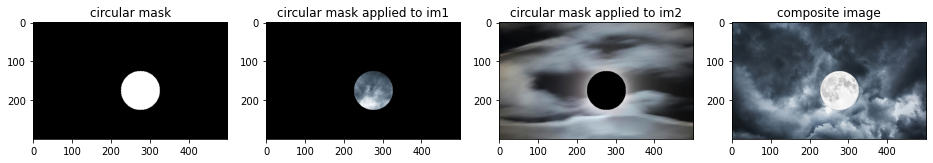

In [177]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=[16,3])
im0 = ax0.imshow(masked_img, cmap='gray')
im1 = ax1.imshow(convert_uint8(np.multiply(masked_img, basketball)))
im2 = ax2.imshow(convert_uint8(np.multiply(1-masked_img, soccer)))
im3 = ax3.imshow(convert_uint8(np.multiply(soccer, masked_img) + np.multiply(basketball, 1-masked_img)))

ax0.set_title("circular mask")
ax1.set_title("circular mask applied to im1")
ax2.set_title("circular mask applied to im2")
ax3.set_title("composite image")

(-0.5, 499.5, 299.5, -0.5)

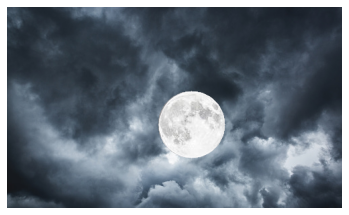

In [178]:
composite_circle = np.multiply(soccer, masked_img) + np.multiply(basketball, 1-masked_img)
plt.imshow(convert_uint8(composite_circle))
plt.axis('off')

(300, 500, 3)


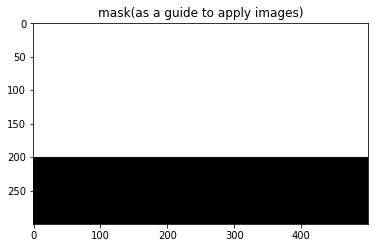

In [179]:
mask_im = np.zeros(soccer.shape, dtype=np.float32)
mask_im[:soccer.shape[0]//2+50, :,:]=1
plt.imshow(mask_im)
plt.title("mask(as a guide to apply images)")
print(mask_im.shape)

(-0.5, 499.5, 299.5, -0.5)

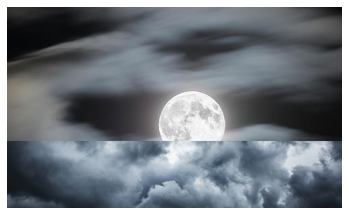

In [180]:
composite = np.multiply(soccer, mask_im) + np.multiply(basketball, 1-mask_im)
plt.imshow(convert_uint8(composite))
plt.axis('off')


In [181]:
def blend(im1, im2, mask, levels):
  """
  blends two images together according to mask
  Inputs:
    im1 = image 1
    im2 = image 2
    mask = binary mask (0, 1)
    levels = the heaight of the pyramid
  Output:
    single combined image
  """
  # Step 1: find composite image
  #composite = np.multiply(im1, mask) + np.multiply(im2, 1 - mask)
  composite = np.multiply(im1, mask) + np.multiply(im2, 1-mask)

  # Step 2: make variables for estimates
  im = guassian_pyramid(composite, levels+1) # 1 by 1 pyramid level
  itr = levels

  #Step 3: let's do collapse according to the 4 steps above
  while itr >= 0:
    print(itr)
    l1 = lapplacian_pyramid(im1, itr)
    l2 = lapplacian_pyramid(im2, itr)
    gm = guassian_pyramid(mask, itr)
    ls = gm * l1 + (1 - gm) * l2
    im = up_sample(im, l1.shape) + ls
    itr -= 1
  return im

In [182]:
height = find_power(masked_img)
blended_im = blend(soccer, basketball, masked_img, height)

9
8
7
6
5
4
3
2
1
0


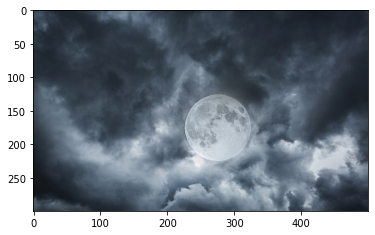

In [183]:
blended_result = convert_uint8(blended_im)
plt.imshow(blended_result)

Text(0.5, 1.0, 'blended')

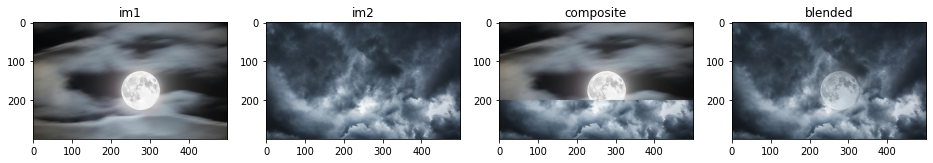

In [184]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=[16,3])
im0 = ax0.imshow(soccer)
im1 = ax1.imshow(basketball)
im2 = ax2.imshow(convert_uint8(composite))
im3 = ax3.imshow(blended_result)

ax0.set_title("im1")
ax1.set_title("im2")
ax2.set_title("composite")
ax3.set_title("blended")

Text(0.5, 1.0, 'blended')

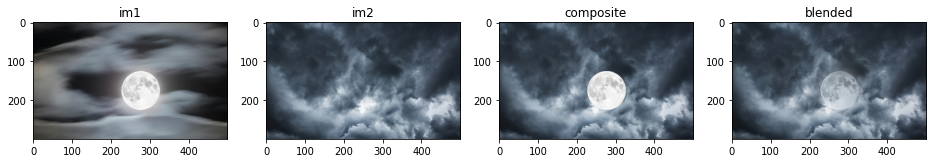

In [185]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=[16,3])
im0 = ax0.imshow(soccer)
im1 = ax1.imshow(basketball)
im2 = ax2.imshow(convert_uint8(np.multiply(soccer, masked_img) + np.multiply(basketball, 1-masked_img)))
im3 = ax3.imshow(blended_result)

ax0.set_title("im1")
ax1.set_title("im2")
ax2.set_title("composite")
ax3.set_title("blended")

In [186]:
print(composite.shape)

(300, 500, 3)


11 levels to get to 1 by 1

In [187]:
print(math.ceil(math.log(1499.5,2)))

11


(1, 1, 3)
(3, 4, 3)
(3, 4, 3)
(5, 8, 3)
(5, 8, 3)
(10, 16, 3)
(10, 16, 3)
(19, 32, 3)


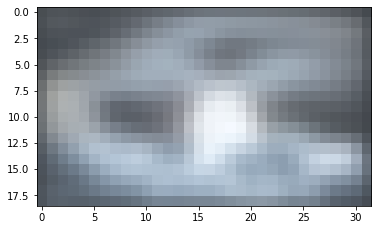

In [188]:
collapsed = convert_uint8(collapse(composite, 4))
plt.imshow(collapsed)

In [189]:
print(guassian_pyramid(im, 4).shape)
difference = convert_uint8(collapse(composite, 4)) - convert_uint8(guassian_pyramid(composite, 4))

(60, 75, 3)
(1, 1, 3)
(3, 4, 3)
(3, 4, 3)
(5, 8, 3)
(5, 8, 3)
(10, 16, 3)
(10, 16, 3)
(19, 32, 3)


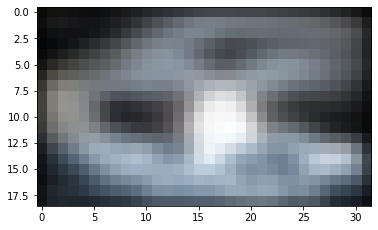

In [190]:
plt.imshow(convert_uint8(guassian_pyramid(composite, 4)))

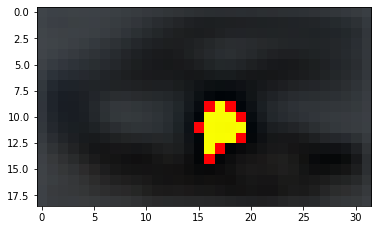

In [191]:
plt.imshow(difference)

(60, 75, 3)


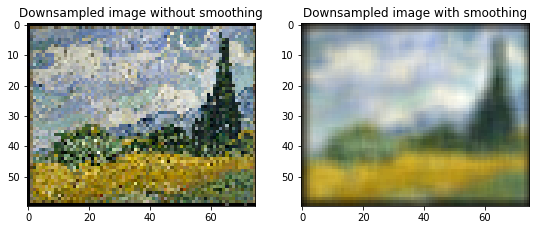

In [192]:
down_sample_one_im = down_sample_one(im, 4, smoothing_kern)
smoothed = convert_uint8(convolve_rgb(down_sample_one_im, smoothing_kern))
print(down_sample_one_im.shape)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[9, 4])
ax0.set_title("Downsampled image without smoothing")
ax1.set_title("Downsampled image with smoothing")

im0 = ax0.imshow(down_sample_one_im)
im1 = ax1.imshow(smoothed)

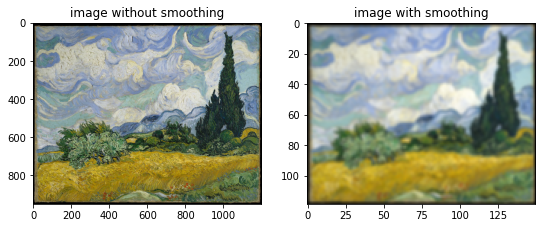

In [193]:
guassian_pyramid_im = guassian_pyramid(im, 3)
guassian_pyramid_im = convert_uint8(guassian_pyramid_im)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=[9, 4])
ax0.set_title("image without smoothing")
ax1.set_title("image with smoothing")

im0 = ax0.imshow(im)
im1 = ax1.imshow(guassian_pyramid_im)

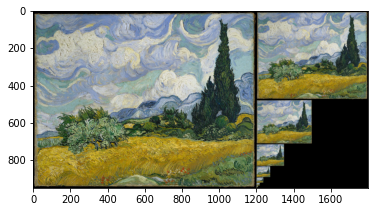

In [194]:
combined = image_combining(im, 9)
plt.imshow(combined)

In [195]:
#small test image
small_test = np.zeros((2, 2, 3), np.float32)
small_test[0, 0,:] = 1
small_test[0, 1,:] = 0.5
small_test[1, 0,:] = 0.5
small_test[1, 1,:] = 0.2
print(small_test.shape)

(2, 2, 3)


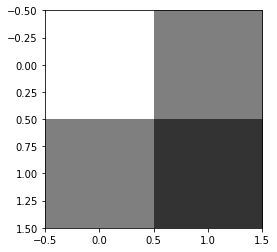

In [196]:
plt.imshow(small_test)

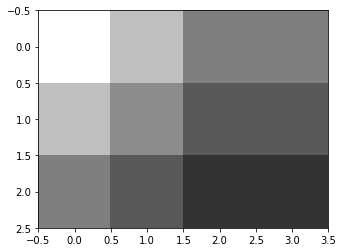

In [197]:
upsample = up_sample(small_test, (3, 4, 3))
plt.imshow(upsample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


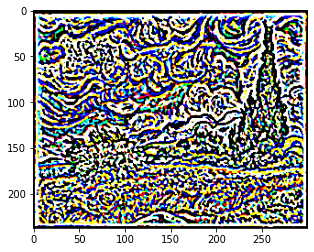

In [198]:
lapplacian_im = lapplacian_pyramid(im, 2)
plt.imshow(lapplacian_im)

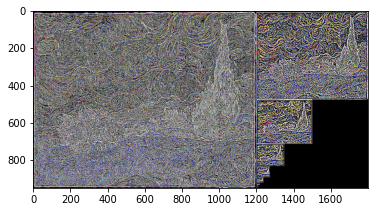

In [199]:
combined_l = image_combining_lapplasian(im, 9)
plt.imshow(combined_l)